# 1-/ Gestion des données

In [4]:
!pip install pydataset 
from pydataset import data
! pip install yfinance
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import statistics as stat
import math
from scipy.stats import norm
from scipy.optimize import minimize
!pip install nbconvert[webpdf]
!jupyter nbconvert --to webpdf --allow-chromium-download Etude_Action.ipynb

[NbConvertApp] Converting notebook Etude_Action.ipynb to webpdf
[NbConvertApp] Building PDF
[INFO] Starting Chromium download.

  0%|          | 0.00/137M [00:00<?, ?b/s]
  0%|          | 51.2k/137M [00:00<04:37, 492kb/s]
  0%|          | 102k/137M [00:00<04:34, 498kb/s] 
  0%|          | 246k/137M [00:00<02:29, 917kb/s]
  0%|          | 563k/137M [00:00<01:16, 1.79Mb/s]
  1%|          | 1.25M/137M [00:00<00:38, 3.57Mb/s]
  2%|2         | 2.89M/137M [00:00<00:17, 7.86Mb/s]
  5%|5         | 6.85M/137M [00:00<00:07, 18.1Mb/s]
  8%|8         | 11.0M/137M [00:00<00:04, 25.2Mb/s]
 10%|9         | 13.6M/137M [00:00<00:05, 23.3Mb/s]
 13%|#3        | 18.4M/137M [00:01<00:03, 30.5Mb/s]
 17%|#7        | 23.9M/137M [00:01<00:03, 37.4Mb/s]
 21%|##1       | 29.3M/137M [00:01<00:02, 42.2Mb/s]
 25%|##5       | 34.2M/137M [00:01<00:02, 43.8Mb/s]
 29%|##8       | 39.2M/137M [00:01<00:02, 45.4Mb/s]
 32%|###2      | 43.9M/137M [00:01<00:02, 45.8Mb/s]
 36%|###5      | 48.9M/137M [00:01<00:01, 47.0Mb/s]
 3

In [2]:
# On télécharge les données boursières quotidiennes via Yahoo Finance

données = yf.download('AAPL' ,start="2013-01-01", end="2023-01-01", interval="1d")
Apple = données['Close']

données = yf.download('KO' ,start="2013-01-01", end="2023-01-01", interval="1d")
Coca = données['Close']

données = yf.download('AMZN' ,start="2013-01-01", end="2023-01-01", interval="1d")
Amazon = données['Close']

données = yf.download('INTC' ,start="2013-01-01", end="2023-01-01", interval="1d")
Intel = données['Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [3]:
# Creation DataFrame avec nos données puis on les réarrange pour avoir les dates en ordonnées et on renomme les colonnes
df = pd.DataFrame([Apple,Coca,Amazon,Intel])
df = df.T
df.columns = ['Apple', 'Coca','Amazon','Intel']
df

,Apple,Coca,Amazon,Intel
Date,,,,
2013-01-02,19.608213,37.599998,12.865500,21.379999
2013-01-03,19.360714,37.599998,12.924000,21.320000
2013-01-04,18.821428,37.660000,12.957500,21.160000
2013-01-07,18.710714,37.299999,13.423000,21.250000
2013-01-08,18.761070,37.040001,13.319000,21.090000
...,...,...,...,...
2022-12-23,131.860001,63.820000,85.250000,26.090000
2022-12-27,130.029999,64.209999,83.040001,25.940001
2022-12-28,126.040001,63.570000,81.820000,25.540001


In [4]:
# On crée notre DataFrame de performance 
returns = df.pct_change()
returns = returns.dropna()
returns

,Apple,Coca,Amazon,Intel
Date,,,,
2013-01-03,-0.012622,0.000000,0.004547,-0.002806
2013-01-04,-0.027855,0.001596,0.002592,-0.007505
2013-01-07,-0.005882,-0.009559,0.035925,0.004253
2013-01-08,0.002691,-0.006970,-0.007748,-0.007529
2013-01-09,-0.015629,-0.000270,-0.000113,0.017070
...,...,...,...,...
2022-12-23,-0.002798,0.007578,0.017425,0.004621
2022-12-27,-0.013878,0.006111,-0.025924,-0.005749
2022-12-28,-0.030685,-0.009967,-0.014692,-0.015420


# 2-/ Statistiques 

In [130]:
def returns_ann(r, periode_par_an): # on annualise les performances   
    compounded_growth = (1+r).prod()
    n_periode = r.shape[0]
    return compounded_growth**(periode_par_an/n_periode)-1

def vol_ann(r, periode_par_an):#on annualise la volatilité 
    return r.std()*(periode_par_an**0.5)

def ratio_sharpe(r, taux_sans_risque, periode_par_an):
    # on convertis le taux sans risque annuel en période
    rf_par_periode = (1+taux_sans_risque)**(1/periode_par_an)-1
    excess_ret = r - rf_par_periode
    ann_ex_ret = returns_ann(excess_ret, periode_par_an)
    ann_vol = vol_ann(r, periode_par_an)
    return ann_ex_ret/ann_vol

def drawdown(return_series: pd.Series):# Montre les baisse les plus importante

    wealth_index = 1000*(1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

def skewness(r):
 
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3

def kurtosis(r):    
    demeaned_r = r - r.mean()
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**4).mean()
    return exp/sigma_r**4

In [6]:
returns_ann(returns, 252)

Apple     0.208440
Coca      0.054049
Amazon    0.206653
Intel     0.021457
dtype: float64

In [7]:
vol_ann(returns, 252)

Apple     0.290766
Coca      0.181801
Amazon    0.326109
Intel     0.308377
dtype: float64

In [8]:
ratio_sharpe(returns, 0.03, 252)

Apple     0.595869
Coca      0.128436
Amazon    0.525966
Intel    -0.026919
dtype: float64

In [9]:
def semideviation(r):   
    is_negative = r < 0
    return r[is_negative].std(ddof=0)

In [10]:
semideviation(returns)

Apple     0.013473
Coca      0.009326
Amazon    0.014773
Intel     0.015123
dtype: float64

In [11]:
def var_historic(r, level=5):
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [12]:
var_historic(returns, level=5)

Apple     0.027132
Coca      0.016248
Amazon    0.030627
Intel     0.027669
dtype: float64

In [129]:

def var_gaussian(r, level=5, modified=False): #Parametric Gausian VaR avec ou non la modification de Cornish-Fisher
    
    # compute the Z score assuming it was Gaussian
    z = norm.ppf(level/100)
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = skewness(r)
        k = kurtosis(r)
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k-3)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [99]:
var_gaussian(returns, level=5)

Apple     0.029202
Coca      0.018559
Amazon    0.032827
Intel     0.031673
dtype: float64

In [100]:
var_gaussian(returns, level=5, modified=True)

Apple     0.027775
Coca      0.018527
Amazon    0.028407
Intel     0.027570
dtype: float64

<AxesSubplot:title={'center':'Hedge Fund Indices: VaR at 5%'}>

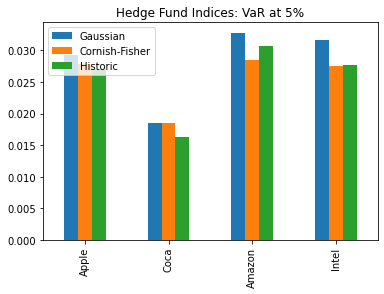

In [103]:
var_table = [var_gaussian(returns), 
             var_gaussian(returns, modified=True), 
             var_historic(returns)]
comparison = pd.concat(var_table, axis=1)
comparison.columns=['Gaussian', 'Cornish-Fisher', 'Historic']
comparison.plot.bar(title="Hedge Fund Indices: VaR at 5%")

# 3-/ Gestion de Portefeuille

In [53]:
def portfolio_return(weights, returns):
    return weights.T @ returns

def portfolio_vol(weights, covmat):
    return (weights.T @ covmat @ weights)**0.5


In [54]:
cov = returns.cov()
cov

,Apple,Coca,Amazon,Intel
Apple,0.000335,0.000072,0.000191,0.000182
Coca,0.000072,0.000131,0.000057,0.000082
Amazon,0.000191,0.000057,0.000422,0.000160
Intel,0.000182,0.000082,0.000160,0.000377


In [55]:
def minimize_vol(target_return, er, cov):# donne le poids optimal de chaque actifs pour une volatilité maximale donnée
    
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n 

    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    return_is_target = {'type': 'eq',
                        'args': (er,),
                        'fun': lambda weights, er: target_return - portfolio_return(weights,er)
    }
    weights = minimize(portfolio_vol, init_guess,
                       args=(cov,), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,return_is_target),
                       bounds=bounds)
    return weights.x

In [56]:
minimize_vol(0.15, returns_ann(returns,252), cov)

array([3.45317005e-01, 3.75286118e-01, 2.79396877e-01, 5.55111512e-17])

#### Pour une volatilité maxiamle de 0.15, notre portefeuille sera composé a 34% d'Apple, 37% de Coca et 28% d'Amazon

In [104]:
def optimal_weights(n_points, er, cov):
    """
    """
    target_rs = np.linspace(er.min(), er.max(), n_points)
    weights = [minimize_vol(target_return, er, cov) for target_return in target_rs]
    return weights

def plot_ef(n_points, er, cov): #affiche la frontière efficiente 
    
    weights = optimal_weights(n_points, er, cov) 
    rets = [portfolio_return(w, er) for w in weights]
    vols = [portfolio_vol(w, cov) for w in weights]
    ef = pd.DataFrame({
        "Returns": rets, 
        "Volatility": vols
    })
    return ef.plot.line(x="Volatility", y="Returns", style='.-')

<AxesSubplot:xlabel='Volatility'>

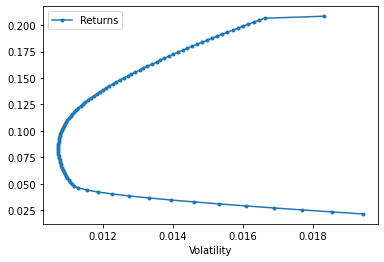

In [58]:
plot_ef(100, returns_ann(returns,252), cov)

In [59]:
def msr(riskfree_rate, er, cov): # donne le poids optimal de chaque actifs pour maximiser le ratio de Sharpe
    
    n = er.shape[0]
    init_guess = np.repeat(1/n, n)
    bounds = ((0.0, 1.0),) * n # an N-tuple of 2-tuples!
    # construct the constraints
    weights_sum_to_1 = {'type': 'eq',
                        'fun': lambda weights: np.sum(weights) - 1
    }
    def neg_sharpe(weights, riskfree_rate, er, cov): # le négatif du ratio de Sharpe
        
        r = portfolio_return(weights, er)
        vol = portfolio_vol(weights, cov)
        return -(r - riskfree_rate)/vol

    weights = minimize(neg_sharpe, init_guess,
                       args=(riskfree_rate, er, cov), method='SLSQP',
                       options={'disp': False},
                       constraints=(weights_sum_to_1,),
                       bounds=bounds)
    return weights.x

In [60]:
msr(0.03, returns_ann(returns,252), cov)

array([6.22395325e-01, 0.00000000e+00, 3.77604675e-01, 3.19704116e-15])

#### Le portefeuille qui maximise le ratio de Sharpe est composé à 62% d'Apple et 37% d'Amazon

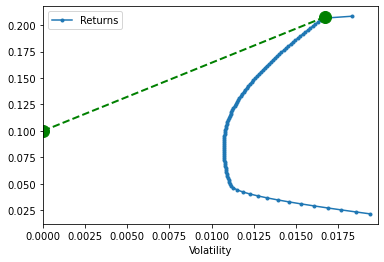

In [105]:
# plot Frontiere efficiente
ax = plot_ef(100, returns_ann(returns,252), cov)
ax.set_xlim(left = 0)
# MSR
rf = 0.1
w_msr = msr(rf, returns_ann(returns,252), cov)
r_msr = portfolio_return(w_msr, returns_ann(returns,252))
vol_msr = portfolio_vol(w_msr, cov)
# CML
cml_x = [0, vol_msr]
cml_y = [rf, r_msr]
ax.plot(cml_x, cml_y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [62]:
r_msr, vol_msr

(0.2077737618504759, 0.01672542670746284)

#### Le portefeuille MSR offre une espérance de rendement de 0.2 avec une volatilité de 0.016 

# 4-/ Constant proportion portfolio insurance


In [136]:
risky_r = returns

safe_r = pd.DataFrame().reindex_like(risky_r)
safe_r.values[:] = 0.03/12 
start = 1000 
floor = 0.80 

In [137]:
# mise en place des paramètre du CPPI
dates = risky_r.index
n_steps = len(dates)
account_value = start
floor_value = start*floor
m = 3

# DataFrames pour sauvegarder les données
account_history = pd.DataFrame().reindex_like(risky_r)
risky_w_history = pd.DataFrame().reindex_like(risky_r)
cushion_history = pd.DataFrame().reindex_like(risky_r)

In [146]:
def run_cppi(risky_r, safe_r=None, m=3, start=1000, floor=0.8, riskfree_rate=0.03, drawdown=None):
    # Fait un Backtest du CPPI
    
    
    # Paramètres
    dates = risky_r.index
    n_steps = len(dates)
    account_value = start
    floor_value = start*floor
    peak = account_value
    if isinstance(risky_r, pd.Series): 
        risky_r = pd.DataFrame(risky_r, columns=["R"])

    if safe_r is None:
        safe_r = pd.DataFrame().reindex_like(risky_r)
        safe_r.values[:] = riskfree_rate/12 # fast way to set all values to a number
    
    account_history = pd.DataFrame().reindex_like(risky_r)
    risky_w_history = pd.DataFrame().reindex_like(risky_r)
    cushion_history = pd.DataFrame().reindex_like(risky_r)
    floorval_history = pd.DataFrame().reindex_like(risky_r)
    peak_history = pd.DataFrame().reindex_like(risky_r)

    for step in range(n_steps):
        if drawdown is not None:
            peak = np.maximum(peak, account_value)
            floor_value = peak*(1-drawdown)
        cushion = (account_value - floor_value)/account_value
        risky_w = m*cushion
        risky_w = np.minimum(risky_w, 1)
        risky_w = np.maximum(risky_w, 0)
        safe_w = 1-risky_w
        risky_alloc = account_value*risky_w
        safe_alloc = account_value*safe_w
        
        account_value = risky_alloc*(1+risky_r.iloc[step]) + safe_alloc*(1+safe_r.iloc[step])
      
        cushion_history.iloc[step] = cushion
        risky_w_history.iloc[step] = risky_w
        account_history.iloc[step] = account_value
        floorval_history.iloc[step] = floor_value
        peak_history.iloc[step] = peak
    risky_wealth = start*(1+risky_r).cumprod()
    backtest_result = {
        "Wealth": account_history,
        "Risky Wealth": risky_wealth, 
        "Risk Budget": cushion_history,
        "Risky Allocation": risky_w_history,
        "m": m,
        "start": start,
        "floor": floor,
        "risky_r":risky_r,
        "safe_r": safe_r,
        "drawdown": drawdown,
        "peak": peak_history,
        "floor": floorval_history
    }
    return backtest_result

In [147]:
def summary_stats(r, riskfree_rate=0.03):
    # donne les stat descriptives du CPPI
    
    ann_r = r.aggregate(returns_ann, periode_par_an=12)
    ann_vol = r.aggregate(vol_ann, periode_par_an=12)
    ann_sr = r.aggregate(ratio_sharpe, taux_sans_risque=riskfree_rate, periode_par_an=12)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.aggregate(skewness)
    kurt = r.aggregate(kurtosis)
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd
    })

<AxesSubplot:xlabel='Date'>

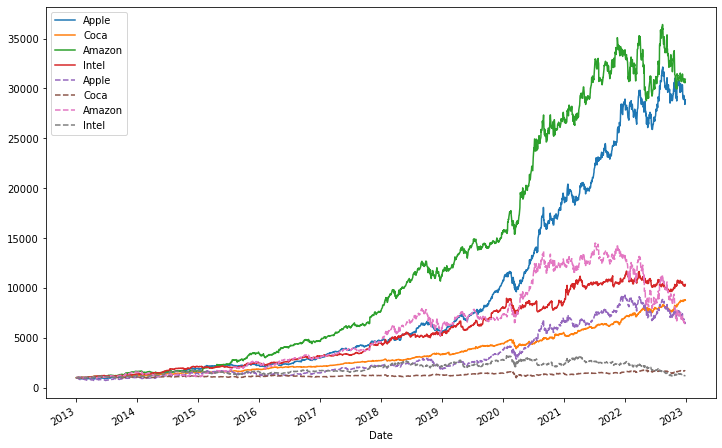

In [151]:
btr = run_cppi(returns, drawdown=0.25)
ax = btr["Wealth"].plot(figsize=(12,8))
btr["Risky Wealth"].plot(ax=ax, style="--")

In [149]:
summary_stats(btr["Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]


,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Apple,0.016213,0.039324,-0.341274,-0.174586
Coca,0.010413,0.025898,-0.736115,-0.188350
Amazon,0.016482,0.043933,-0.299510,-0.184549
Intel,0.011215,0.040398,-0.452619,-0.194361


In [150]:
summary_stats(btr["Risky Wealth"].pct_change().dropna())[["Annualized Return", "Annualized Vol", "Sharpe Ratio", "Max Drawdown"]]

,Annualized Return,Annualized Vol,Sharpe Ratio,Max Drawdown
Apple,0.009121,0.063456,-0.320301,-0.387297
Coca,0.002511,0.039680,-0.674281,-0.375353
Amazon,0.008967,0.071177,-0.287683,-0.561453
Intel,0.001025,0.067306,-0.419052,-0.634292


#### La gestion en CPPI de nos 4 actifs(ligne continue) nous permet d'augmenter la rentabilité espérée et de baisser la volatilité et la perte maximale par rapport à une gestion classique des ces actifs (ligne discontinue)